In [6]:
########################################
# Import Data
########################################
import pandas as pd

#Import Data from whole exercise and for first set
df = pd.read_csv('data.csv', sep=',', header=0)
s1 = pd.read_csv('set1.csv', sep=',', header=0)
#clean dataframes
df = df.rename(columns=lambda x: x.strip())
df = df.dropna()
s1 = s1.rename(columns=lambda x: x.strip())
s1 = s1.dropna()
print('Whole exercise dataset:')
print(df)
print('Set 1 dataset')
print(s1)

Whole exercise dataset:
    ID GROUPE MUSCLE  SWE_perc  SWE_raw  SWE_dist  ACTIVATION  LRELATIVE  \
0    1    NHE     SM       0.0     -0.1      0.00    0.341907   0.646984   
1    2    NHE     SM       6.0      2.0      0.18    0.602638   0.529459   
2    3    NHE     SM       0.0     -1.4      0.00    0.418067   0.683204   
3    4    NHE     SM       0.0     -7.6      0.00    0.397005   0.567855   
4    5    NHE     SM       0.0     -7.6      0.00    0.464852   0.718161   
..  ..    ...    ...       ...      ...       ...         ...        ...   
58  17     DL     BF      31.1      9.9      0.60    0.116118   1.288176   
59  18     DL     BF       0.0     -2.5      0.00    0.596198   1.130732   
60  19     DL     BF      17.6      6.4      0.66    0.340944   1.209678   
61  20     DL     BF      25.7      8.9      0.43    0.340485   1.302315   
62  21     DL     BF      20.1     11.3      0.66    0.305264   1.195297   

    LRELATIVE_pic       F_V  ForceRelative  ForceRelative_pic  

Data normality test will be performed on ['SWE_perc', 'SWE_raw', 'SWE_dist', 'ACTIVATION', 'LRELATIVE', 'LRELATIVE_pic', 'F_V', 'ForceRelative', 'ForceRelative_pic', 'ChargeInterne']
SWE_perc             stat=0.798, p=0.000          Exp     FAIL
SWE_perc             stat.=0.792, p=0.000    Shift+Log   REFAIL
SWE_perc             stat.=0.877, p=0.000  yeo-johnson   REFAIL
SWE_raw              stat=0.958, p=0.031          Exp     FAIL
SWE_raw              stat.=nan, p=nan    Shift+Log   REFAIL
SWE_raw              stat.=0.985, p=0.636  yeo-johnson       OK


C:\Users\doguet-v-3\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


SWE_dist             stat=0.869, p=0.000          Exp     FAIL
SWE_dist             stat.=0.850, p=0.000    Shift+Log   REFAIL
SWE_dist             stat.=0.870, p=0.000  yeo-johnson   REFAIL
ACTIVATION           stat=0.959, p=0.033          Exp     FAIL
ACTIVATION           stat.=0.969, p=0.113          Log       OK
ACTIVATION           stat.=0.981, p=0.421      box-cox       OK
LRELATIVE            stat=0.928, p=0.001          Exp     FAIL
LRELATIVE            stat.=0.913, p=0.000          Log   REFAIL
LRELATIVE            stat.=0.929, p=0.001      box-cox   REFAIL
LRELATIVE_pic        stat=0.916, p=0.000          Exp     FAIL
LRELATIVE_pic        stat.=0.911, p=0.000          Log   REFAIL
LRELATIVE_pic        stat.=0.915, p=0.000      box-cox   REFAIL
F_V                  stat=0.989, p=0.840          Exp       OK
ForceRelative        stat=0.939, p=0.004          Exp     FAIL
ForceRelative        stat.=0.989, p=0.870          Log       OK
ForceRelative        stat.=0.991, p=0.914     

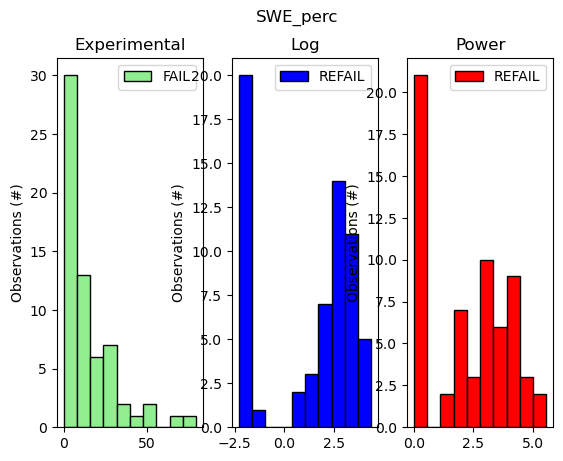

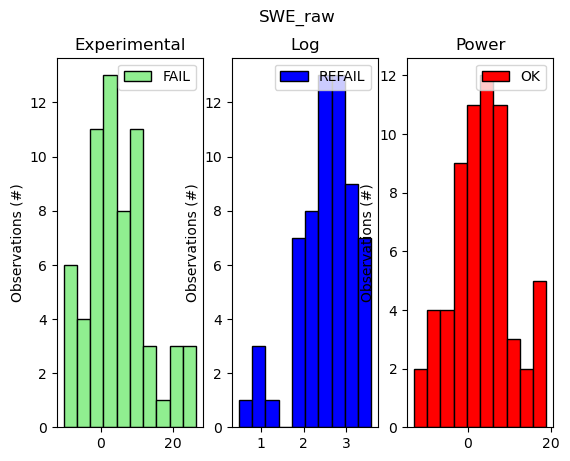

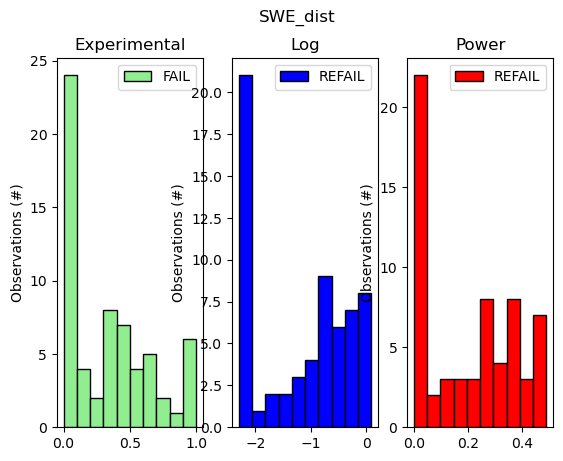

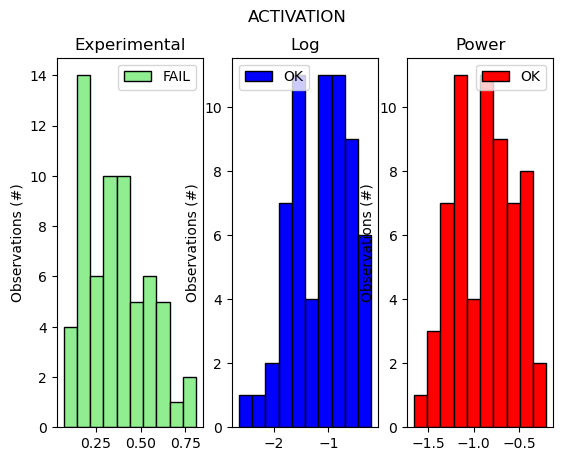

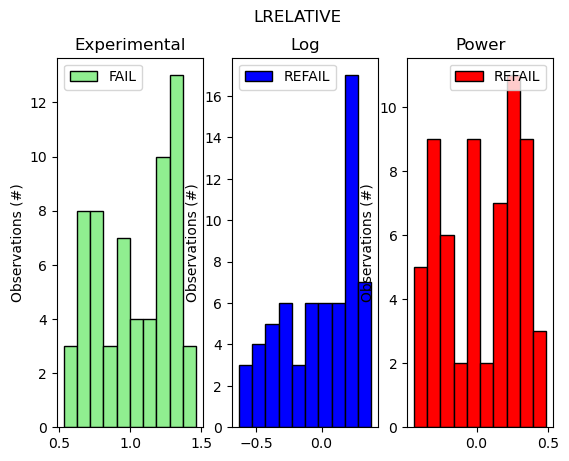

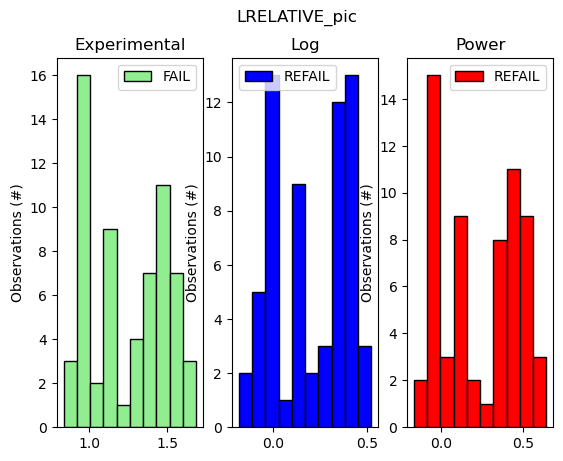

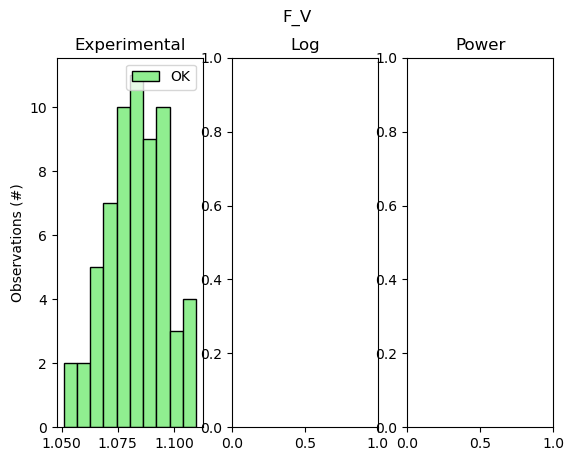

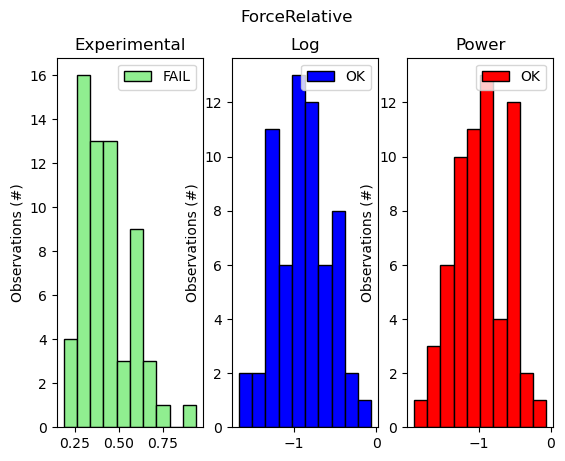

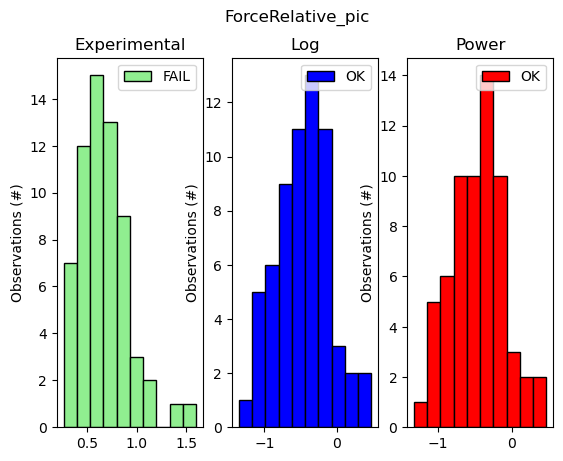

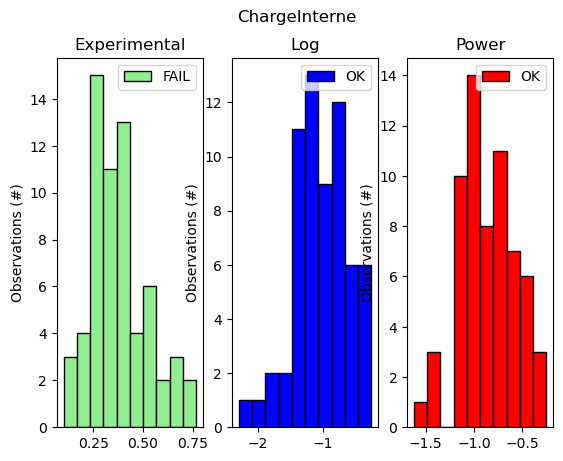

In [50]:
########################################
# Check Normality && Transform
########################################
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import shapiro, pearsonr, linregress
from sklearn import preprocessing

"""
Shapiro-Wilk test (doc. [1]) is used to test normality for all variables separately,
for the whole dataset at once (62 rows, mixing groups and muscles).
/!\ This should be checked since each subject is represented on 3 different rows. /!\
[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

When normality test fails, data are transformed according to both log transform and power transform [2] and retesed.
[2] https://scikit-learn.org/stable/modules/preprocessing.html

Normality is only tested for the whole exercise (not set 1) and data are uniformilly transformed
for both "whole exercise" and "set 1" if test fails.
"""

#Create independant copies of dataframes for data transforming purpose
dftrans = df.copy()
s1trans = s1.copy()
#create a list of column for which normality has to be tested
cols = df.drop(['ID', 'GROUPE', 'MUSCLE'], axis=1).columns.tolist()
print(f'Data normality test will be performed on {cols}')

#Enumerate all columns to test, perform Shapiro test and Plot data & transformed data if any.
for i, c in enumerate(cols):
    #prepare figure
    fig, axs = plt.subplots(1, 3)#use 3 columns to show experimental data, Log transformed and Power transformed data
    fig.suptitle(c)
    color = ['lightgreen', 'blue', 'red']
    #get the variable to test in initial dataframes
    y = df[c]
    ys1 = s1[c]
    #perform shapiro wilk test on whole exercise only
    stat, p = shapiro(y)
    #check result and process accordingly
    trans = 'Exp'
    if p > .05:
        norm = "OK"
        #show results
        print(f'{c:<20} stat={stat:.3f}, p={p:.3f} {trans:>12} {norm:>8}')
        line = f'{norm}'
        #define output variable identical to input
        yp = y
    else:
        norm = "FAIL"
        #show results
        print(f'{c:<20} stat={stat:.3f}, p={p:.3f} {trans:>12} {norm:>8}')
        line = f'{norm}'
        #then transform data using different ways
        k = 1;
        while True:
            if k > 2:
                break
            if k == 1:
                #make sure to handle only positive values since log of negative fails
                if np.any(y <= 0):
                    #if so, first shift all values to a constant value so that all data are >= 0 and log them
                    trans = 'Shift+Log'
                    yp = np.array(np.log(y + abs(np.min(y) + .1)))      #shifted log transform
                else:
                    trans = 'Log'
                    yp = np.array(np.log(y))      #only log transform
                #replace inf value (if any zero value)
                yp[np.where(np.isinf(yp))] = 0
            elif k == 2:
                try:
                    # Parametric Power Transform that only accept positive values
                    trans = 'box-cox'
                    pt = preprocessing.PowerTransformer(method=trans, standardize=False)
                    yp = pt.fit_transform(np.array(y).reshape(-1, 1))
                    #do the same for set 1 dataset
                    ys1p = pt.fit_transform(np.array(ys1).reshape(-1, 1))
                except:
                    # Parametric Power Transform
                    trans = 'yeo-johnson'
                    pt = preprocessing.PowerTransformer(method=trans, standardize=False)
                    yp = pt.fit_transform(np.array(y).reshape(-1, 1))
                    #do the same for set 1 dataset
                    ys1p = pt.fit_transform(np.array(ys1).reshape(-1, 1))
                #reshape
                yp = yp.reshape(1, -1)[0]
                ys1p = ys1p.reshape(1, -1)[0]
            #Retest normality with tranformed data
            stat, p = shapiro(yp)
            #show result
            print(f'{c:<20} stat.={stat:.3f}, p={p:.3f} {trans:>12} {"OK" if p > 0.05 else "REFAIL":>8}')
            line2 = f'{"OK" if p > 0.05 else "REFAIL"}'
            #show modifyed data
            axs[k].hist(yp,
                        bins=10,
                        color=color[k],
                        ec='black',
                        label=line2)
            axs[k].set_ylabel('Observations (#)')
            axs[k].legend(facecolor='white')
            #increment
            k += 1
    #modify in transformad dataframes
    dftrans[c] = pd.Series(yp)
    s1trans[c] = pd.Series(ys1p)
    #plot raw data
    axs[0].hist(y,
                bins=10,
                color=color[0],
                ec='black',
                label=line)
    axs[0].set_ylabel('Observations (#)')
    axs[0].legend(facecolor='white')
    axs[0].set_title('Experimental')
    axs[2].set_title('Power')
    axs[1].set_title('Log')
